In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install Java8 (Spark không tương thích tốt với các phiên bản Java khác)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# download Spark (ví dụ với spark-3.5.1)
!wget -q https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz

!tar xf spark-3.5.1-bin-hadoop3.tgz

# install findspark
!pip install -q findspark


# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

# Quick Installation Test
import findspark
findspark.init()
from pyspark.sql import SparkSession
# Check the pyspark version
import pyspark
print(pyspark.__version__)


3.5.1


In [ ]:
from pyspark.sql import SparkSession
import numpy as np
from math import sqrt

spark = SparkSession.builder.appName("SGD-Recommender").getOrCreate()

In [ ]:
user_index = spark.read.parquet("/content/drive/MyDrive/XuLyDuLieuLon/mappings/user_index.parquet")
item_index = spark.read.parquet("/content/drive/MyDrive/XuLyDuLieuLon/mappings/item_index.parquet")
item_means = spark.read.parquet("/content/drive/MyDrive/XuLyDuLieuLon/preprocessed/item_means.parquet")

train_df_norm = spark.read.parquet("/content/drive/MyDrive/XuLyDuLieuLon/preprocessed/train_norm.parquet")
valid_df_norm = spark.read.parquet("/content/drive/MyDrive/XuLyDuLieuLon/preprocessed/valid_norm.parquet")
test_df_norm  = spark.read.parquet("/content/drive/MyDrive/XuLyDuLieuLon/preprocessed/test_norm.parquet")

In [ ]:
print(user_index)
user_index.show(5)
print(item_index)
item_index.show(5)
print(item_means)
item_means.show(5)
print(train_df_norm)
train_df_norm.show()
print(valid_df_norm)
valid_df_norm.show()
print(test_df_norm)
test_df_norm.show()


DataFrame[user_id: string, userIndex: int]
+--------------------+---------+
|             user_id|userIndex|
+--------------------+---------+
|AE22236AFRRSMQIKG...|        0|
|AE222H3FGXWLHRFUM...|        1|
|AE224QIIILW6WVFAE...|        2|
|AE224XBMLKDOWJRHA...|        3|
|AE2255XXPI47TT6JO...|        4|
+--------------------+---------+
only showing top 5 rows

DataFrame[parent_asin: string, itemIndex: int]
+-----------+---------+
|parent_asin|itemIndex|
+-----------+---------+
| 0307449440|        0|
| 0307965570|        1|
| 0385344945|        2|
| 0394820371|        3|
| 0399211942|        4|
+-----------+---------+
only showing top 5 rows

DataFrame[itemIndex: int, item_mean: double]
+---------+-----------------+
|itemIndex|        item_mean|
+---------+-----------------+
|    68090|4.181818181818182|
|    43852|4.513513513513513|
|    46952|4.266666666666667|
|    69048|4.464285714285714|
|    43935|             4.42|
+---------+-----------------+
only showing top 5 rows

DataFra

Epoch 01 | Train RMSE=0.9785 | Val RMSE=1.2672 | Train MAE=0.6171 | Val MAE=0.8128
Epoch 02 | Train RMSE=0.9740 | Val RMSE=1.2653 | Train MAE=0.6205 | Val MAE=0.8140
Epoch 03 | Train RMSE=0.9704 | Val RMSE=1.2638 | Train MAE=0.6215 | Val MAE=0.8145
Epoch 04 | Train RMSE=0.9673 | Val RMSE=1.2626 | Train MAE=0.6213 | Val MAE=0.8146
Epoch 05 | Train RMSE=0.9642 | Val RMSE=1.2615 | Train MAE=0.6201 | Val MAE=0.8142
Epoch 06 | Train RMSE=0.9610 | Val RMSE=1.2606 | Train MAE=0.6182 | Val MAE=0.8136
Epoch 07 | Train RMSE=0.9575 | Val RMSE=1.2597 | Train MAE=0.6156 | Val MAE=0.8127
Epoch 08 | Train RMSE=0.9536 | Val RMSE=1.2589 | Train MAE=0.6123 | Val MAE=0.8116
Epoch 09 | Train RMSE=0.9493 | Val RMSE=1.2581 | Train MAE=0.6084 | Val MAE=0.8103
Epoch 10 | Train RMSE=0.9443 | Val RMSE=1.2573 | Train MAE=0.6038 | Val MAE=0.8088
Epoch 11 | Train RMSE=0.9387 | Val RMSE=1.2565 | Train MAE=0.5986 | Val MAE=0.8072
Epoch 12 | Train RMSE=0.9323 | Val RMSE=1.2556 | Train MAE=0.5927 | Val MAE=0.8055
Epoc

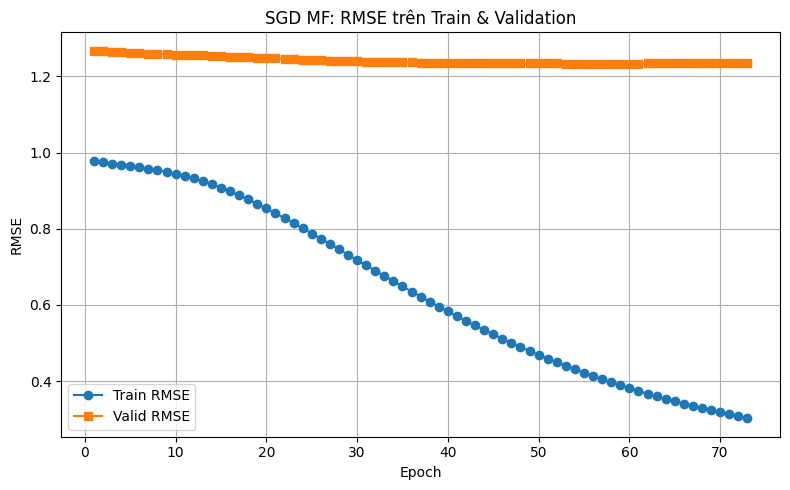

📊 Biểu đồ RMSE đã được lưu tại: sgd_rmse_curve.png


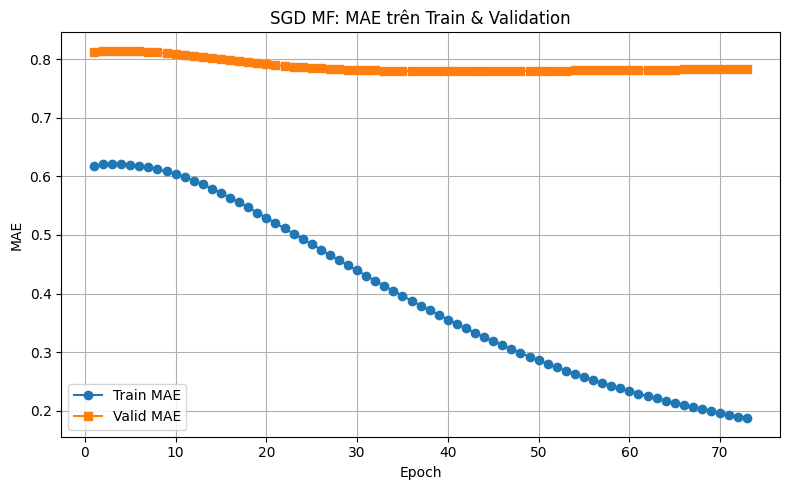

📊 Biểu đồ MAE đã được lưu tại: sgd_mae_curve.png


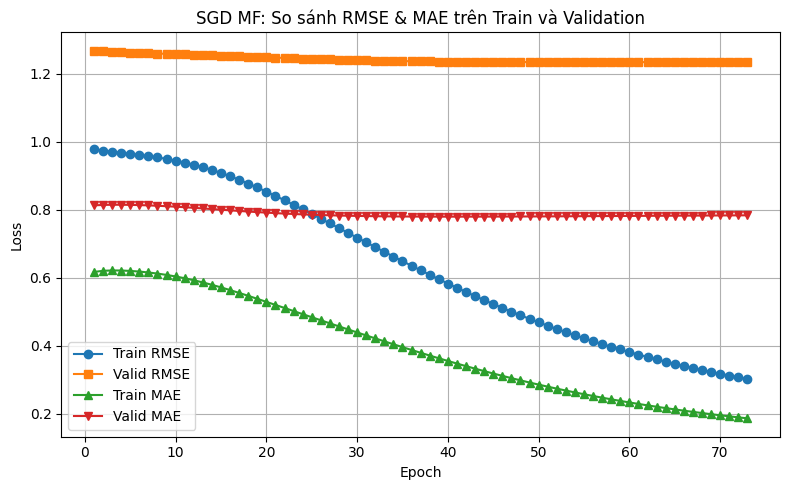

📊 Biểu đồ RMSE + MAE đã được lưu tại: sgd_rmse_mae_curve.png


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import numpy as np
import random
import matplotlib.pyplot as plt


# Tham số mô hình
num_users = user_index.select("userIndex").count()
num_items = item_index.select("itemIndex").count()

K = 50
lr = 0.01
reg = 0.05
epochs = 100
patience = 20

# Khởi tạo ma trận
# P = np.random.normal(0, 0.1, (num_users, K))
# Q = np.random.normal(0, 0.1, (num_items, K))
P = np.random.uniform(0, 0.1, (num_users, K))
Q = np.random.uniform(0, 0.1, (num_items, K))

# Chuyển dữ liệu sang RDD
train_rdd = train_df_norm.select("userIndex", "itemIndex", "rating_norm").rdd.map(tuple)
valid_rdd = valid_df_norm.select("userIndex", "itemIndex", "rating_norm").rdd.map(tuple)
test_rdd  = test_df_norm.select("userIndex", "itemIndex", "rating_norm").rdd.map(tuple)

# ----------------- Hàm tính RMSE và MAE -----------------
def compute_rmse_mae(rdd, P, Q):
    errors = rdd.map(lambda x: float(np.dot(P[int(x[0])], Q[int(x[1])])) - x[2])
    squared_err = errors.map(lambda e: e**2).mean()
    abs_err = errors.map(lambda e: abs(e)).mean()
    return np.sqrt(squared_err), abs_err

# ----------------- Train bằng SGD -----------------
best_val_rmse = float('inf')
patience_counter = 0
train_history_rmse, valid_history_rmse = [], []
train_history_mae, valid_history_mae = [], []

for epoch in range(epochs):
    samples = train_rdd.takeSample(False, train_rdd.count())
    total_loss_sq = 0
    total_loss_abs = 0

    for (u, i, r) in samples:
        u, i = int(u), int(i)
        pred = np.dot(P[u], Q[i])
        err = r - pred

        # Cập nhật P, Q
        P[u] += lr * (err * Q[i] - reg * P[u])
        Q[i] += lr * (err * P[u] - reg * Q[i])

        total_loss_sq += err ** 2
        total_loss_abs += abs(err)

    # RMSE & MAE trên train
    train_rmse = np.sqrt(total_loss_sq / len(samples))
    train_mae = total_loss_abs / len(samples)
    train_history_rmse.append(train_rmse)
    train_history_mae.append(train_mae)

    # RMSE & MAE trên validation
    val_rmse, val_mae = compute_rmse_mae(valid_rdd, P, Q)
    valid_history_rmse.append(val_rmse)
    valid_history_mae.append(val_mae)

    print(f"Epoch {epoch+1:02d} | Train RMSE={train_rmse:.4f} | Val RMSE={val_rmse:.4f} | Train MAE={train_mae:.4f} | Val MAE={val_mae:.4f}")

    # Early stopping
    if val_rmse < best_val_rmse - 1e-4:
        best_val_rmse = val_rmse
        patience_counter = 0
        best_P, best_Q = P.copy(), Q.copy()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🔹 Early stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
            break

# ----------------- Vẽ & lưu biểu đồ -----------------

# 1️⃣ Biểu đồ RMSE
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_history_rmse)+1), train_history_rmse, label='Train RMSE', marker='o')
plt.plot(range(1, len(valid_history_rmse)+1), valid_history_rmse, label='Valid RMSE', marker='s')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('SGD MF: RMSE trên Train & Validation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("sgd_rmse_curve.png", dpi=300)
plt.show()
print("📊 Biểu đồ RMSE đã được lưu tại: sgd_rmse_curve.png")

# 2️⃣ Biểu đồ MAE
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_history_mae)+1), train_history_mae, label='Train MAE', marker='o')
plt.plot(range(1, len(valid_history_mae)+1), valid_history_mae, label='Valid MAE', marker='s')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('SGD MF: MAE trên Train & Validation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("sgd_mae_curve.png", dpi=300)
plt.show()
print("📊 Biểu đồ MAE đã được lưu tại: sgd_mae_curve.png")

# 3️⃣ Biểu đồ RMSE + MAE kết hợp
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_history_rmse)+1), train_history_rmse, marker='o', label='Train RMSE')
plt.plot(range(1, len(valid_history_rmse)+1), valid_history_rmse, marker='s', label='Valid RMSE')
plt.plot(range(1, len(train_history_mae)+1), train_history_mae, marker='^', label='Train MAE')
plt.plot(range(1, len(valid_history_mae)+1), valid_history_mae, marker='v', label='Valid MAE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD MF: So sánh RMSE & MAE trên Train và Validation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("sgd_rmse_mae_curve.png", dpi=300)
plt.show()
print("📊 Biểu đồ RMSE + MAE đã được lưu tại: sgd_rmse_mae_curve.png")


In [ ]:
# ----------------- Lưu ma trận P, Q -----------------
np.save("best_P.npy", best_P)
np.save("best_Q.npy", best_Q)
print("💾 Ma trận P và Q đã được lưu: best_P.npy, best_Q.npy")


💾 Ma trận P và Q đã được lưu: best_P.npy, best_Q.npy


In [ ]:
from pyspark.sql import functions as F, Window
# Dự đoán
def predict(user_idx, item_idx):
    return float(np.dot(P[int(user_idx)], Q[int(item_idx)]))

predict_udf = F.udf(lambda u, i: float(np.dot(P[int(u)], Q[int(i)])))

# Dự đoán rating chuẩn hóa
pred_df = train_df_norm.withColumn("pred_rating_norm", predict_udf(F.col("userIndex"), F.col("itemIndex")))

# Cộng lại item_mean để ra rating thật
pred_df = pred_df.withColumn("pred_rating", F.col("pred_rating_norm") + F.col("item_mean"))

pred_df.orderBy(F.asc("userIndex")).select("userIndex", "itemIndex", "pred_rating", "rating").show(10)


+---------+---------+------------------+------+
|userIndex|itemIndex|       pred_rating|rating|
+---------+---------+------------------+------+
|        0|    42548| 4.804802273600687|   4.0|
|        0|     4067| 4.788383991803771|   5.0|
|        0|    88053| 4.847739745965452|   5.0|
|        0|    62483| 4.930331250000996|   5.0|
|        0|     2521| 4.055603120520791|   4.0|
|        0|    12069|  4.45437052730342|   4.0|
|        0|    40803|4.9103320777694615|   5.0|
|        0|    35814|4.6034267316113695|   5.0|
|        0|    50946| 4.885398039465069|   5.0|
|        0|    43242| 4.669761447054629|   4.0|
+---------+---------+------------------+------+
only showing top 10 rows



In [ ]:
# Đánh giá trên tập test
test_rmse, test_mae = compute_rmse_mae(test_rdd, best_P, best_Q)
print(f"\n✅ Test RMSE = {test_rmse:.4f}")
print(f"\n✅ Test RMSE = {test_mae:.4f}")

# Tạo cột dự đoán rating cuối cùng
predict_udf = F.udf(lambda u, i: float(np.dot(best_P[int(u)], best_Q[int(i)])))
pred_df = test_df_norm.withColumn("pred_rating_norm", predict_udf(F.col("userIndex"), F.col("itemIndex")))
pred_df = pred_df.withColumn("pred_rating", F.col("pred_rating_norm") + F.col("item_mean"))

pred_df.orderBy(F.asc("userIndex")).select("userIndex", "itemIndex", "pred_rating", "rating").show(10)


✅ Test RMSE = 1.0948

✅ Test RMSE = 0.7040
+---------+---------+------------------+------+
|userIndex|itemIndex|       pred_rating|rating|
+---------+---------+------------------+------+
|        2|    77614| 4.615072987664534|   5.0|
|        2|    79742| 4.610387655798087|   5.0|
|        2|    76997| 4.623047407147297|   5.0|
|        2|    72547|4.6169790634108905|   5.0|
|        2|    76796| 4.620989642797147|   5.0|
|        2|    76053| 4.111742470304503|   5.0|
|        2|    83976| 4.617125517621942|   5.0|
|        2|    87909| 4.904011001266981|   5.0|
|        2|    41576|3.6127506711615025|   5.0|
|        2|    84014|   4.6217945205133|   5.0|
+---------+---------+------------------+------+
only showing top 10 rows



In [ ]:
from pyspark.sql import Window
from pyspark.sql import functions as F

# Xếp hạng thật & dự đoán

# Xếp hạng thật (true_rank) theo rating giảm dần trong từng user
w_true = Window.partitionBy("userIndex").orderBy(F.desc("rating"))
pred_df = pred_df.withColumn("true_rank", F.row_number().over(w_true))

# Xếp hạng dự đoán (pred_rank) theo pred_rating giảm dần trong từng user
w_pred = Window.partitionBy("userIndex").orderBy(F.desc("pred_rating"))
pred_df = pred_df.withColumn("pred_rank", F.row_number().over(w_pred))

pred_df.select("userIndex", "itemIndex", "rating", "pred_rating", "true_rank", "pred_rank").orderBy(F.asc("userIndex")).show(10)

+---------+---------+------+------------------+---------+---------+
|userIndex|itemIndex|rating|       pred_rating|true_rank|pred_rank|
+---------+---------+------+------------------+---------+---------+
|        2|    87909|   5.0| 4.904011001266981|        4|        1|
|        2|    76997|   5.0| 4.623047407147297|        7|        2|
|        2|    84014|   5.0|   4.6217945205133|        5|        3|
|        2|    76796|   5.0| 4.620989642797147|        9|        4|
|        2|    83976|   5.0| 4.617125517621942|        8|        5|
|        2|    72547|   5.0|4.6169790634108905|        2|        6|
|        2|    77614|   5.0| 4.615072987664534|        6|        7|
|        2|    79742|   5.0| 4.610387655798087|        3|        8|
|        2|    76053|   5.0| 4.111742470304503|        1|        9|
|        2|    41576|   5.0|3.6127506711615025|       10|       10|
+---------+---------+------+------------------+---------+---------+
only showing top 10 rows



Precision@K

In [ ]:
# Precision@K
K = 10  # bạn có thể đổi tuỳ ý (ví dụ 5, 10, 20)

# Xác định các item được người dùng thực sự thích (rating >= 4)
liked_df = pred_df.filter(F.col("rating") >= 4)

# Top-K item theo dự đoán
topk_pred = pred_df.filter((F.col("pred_rank") <= K) & (F.col("pred_rating") >= 4))

# Tính số lượng sản phẩm được hệ thống gợi ý cho mỗi user (S)
suggested_count = pred_df.groupBy("userIndex").agg(
    F.count("itemIndex").alias("S")
)

# Giao giữa top-K dự đoán và sản phẩm người dùng thật sự thích
relevant_in_topk = topk_pred.join(
    liked_df.select("userIndex", "itemIndex"),
    on=["userIndex", "itemIndex"],
    how="inner"
)

# Đếm số lượng item đúng (được thích) trong top-K của từng user
relevant_count = relevant_in_topk.groupBy("userIndex").agg(
    F.count("itemIndex").alias("correct_count")
)

# Gộp hai bảng lại để có cả correct_count và S cho mỗi user
precision_user = relevant_count.join(suggested_count, on="userIndex", how="left")

# Tính Precision@K linh hoạt:
# - Nếu S >= K → chia cho K
# - Nếu S < K → chia cho S
precision_user = precision_user.withColumn(
    "precision_at_k",
    F.when(F.col("S") >= F.lit(K),
           F.col("correct_count") / F.lit(K)
    ).otherwise(
           F.col("correct_count") / F.col("S")
    )
)
precision_user.orderBy(F.asc("userIndex")).show(10)
# Nếu muốn tính trung bình Precision@K toàn bộ user
precision_at_k = precision_user.select(F.avg("precision_at_k")).first()[0]

print(f"\n✅ Precision@{K} (linh hoạt) = {precision_at_k:.4f}")



+---------+-------------+---+------------------+
|userIndex|correct_count|  S|    precision_at_k|
+---------+-------------+---+------------------+
|        2|            9| 10|               0.9|
|        5|            5|  7|0.7142857142857143|
|        7|            3|  3|               1.0|
|        8|            7|  7|               1.0|
|       11|            1|  1|               1.0|
|       19|            6|  7|0.8571428571428571|
|       24|            2|  2|               1.0|
|       25|            1|  1|               1.0|
|       28|            1|  2|               0.5|
|       47|            2|  3|0.6666666666666666|
+---------+-------------+---+------------------+
only showing top 10 rows


✅ Precision@10 (linh hoạt) = 0.8878


NDCG@K

In [ ]:
from pyspark.sql import functions as F, Window
import math


# Lấy Top-K item theo thứ hạng dự đoán
w_pred = Window.partitionBy("userIndex").orderBy(F.asc("pred_rank"))
topk_pred = (
    pred_df
    .withColumn("rank_order", F.row_number().over(w_pred))
    .filter(F.col("rank_order") <= K)
)

# Lấy Top-K item theo thứ hạng thật
w_true = Window.partitionBy("userIndex").orderBy(F.asc("true_rank"))
topk_true = (
    pred_df
    .withColumn("rank_order", F.row_number().over(w_true))
    .filter(F.col("rank_order") <= K)
)

# Tính DCG@K cho mỗi user
dcg_df = (
    topk_pred
    .withColumn("dcg_term", F.col("rating") / F.log2(F.col("pred_rank") + F.lit(1)))
    .groupBy("userIndex")
    .agg(F.sum("dcg_term").alias("DCG"))
)

# Tính IDCG@K cho mỗi user
idcg_df = (
    topk_true
    .withColumn("idcg_term", F.col("rating") / F.log2(F.col("true_rank") + F.lit(1)))
    .groupBy("userIndex")
    .agg(F.sum("idcg_term").alias("IDCG"))
)

# Ghép DCG và IDCG để tính NDCG
ndcg_df = (
    dcg_df
    .join(idcg_df, on="userIndex", how="inner")
    .withColumn(
        "NDCG_at_k",
        F.when(F.col("IDCG") == 0, 0).otherwise(F.col("DCG") / F.col("IDCG"))
    )
)

# Tính NDCG trung bình toàn bộ hệ thống
avg_ndcg = ndcg_df.agg(F.avg("NDCG_at_k")).collect()[0][0]



In [ ]:
print(f"📈 Average NDCG@{K}: {avg_ndcg:.4f}")

# Hiển thị top 10 user có NDCG cao nhất
ndcg_df.orderBy(F.desc("NDCG_at_k")).show(10, truncate=False)

📈 Average NDCG@10: 0.9819
+---------+------------------+------------------+---------+
|userIndex|DCG               |IDCG              |NDCG_at_k|
+---------+------------------+------------------+---------+
|28       |5.630929753571458 |5.630929753571458 |1.0      |
|82       |4.0               |4.0               |1.0      |
|47       |9.154648767857287 |9.154648767857287 |1.0      |
|4        |3.0               |3.0               |1.0      |
|55       |12.808031558224252|12.808031558224252|1.0      |
|6        |1.0               |1.0               |1.0      |
|61       |5.0               |5.0               |1.0      |
|8        |18.18999819660374 |18.18999819660374 |1.0      |
|65       |5.0               |5.0               |1.0      |
|17       |4.0               |4.0               |1.0      |
+---------+------------------+------------------+---------+
only showing top 10 rows



Performence đánh giá chung

In [ ]:
import pandas as pd

# ====================== 1️⃣ Kết quả của các mô hình ======================
# (ví dụ: bạn đã đo 3 chỉ số RMSE, Precision@K, NDCG@K cho mỗi mô hình)
model_metrics = [
    {"model": "SGD", "rmse": 1.0948, "precision_k": 0.8878, "ndcg_k": 0.9819},
    {"model": "ALS", "rmse": 0.95, "precision_k": 0.36, "ndcg_k": 0.47},
    {"model": "NCF", "rmse": 1.0878, "precision_k": 0.7952, "ndcg_k": 0.9820},
    {"model": "SVD", "rmse": 1.0634, "precision_k": 0.2064, "ndcg_k": 0.9651}
]

df = pd.DataFrame(model_metrics)

# ====================== 2️⃣ Tính min-max của RMSE ======================
rmse_min, rmse_max = df["rmse"].min(), df["rmse"].max()

# ====================== 3️⃣ Trọng số cho từng metric ======================
w_rmse = 0.4
w_prec = 0.4
w_ndcg = 0.2

# ====================== 4️⃣ Chuẩn hóa RMSE và tính điểm tổng hợp ======================
df["rmse_norm"] = 1 - (df["rmse"] - rmse_min) / (rmse_max - rmse_min)
df["overall_score"] = (
    w_rmse * df["rmse_norm"]
    + w_prec * df["precision_k"]
    + w_ndcg * df["ndcg_k"]
)

# ====================== 5️⃣ Sắp xếp mô hình theo điểm tổng hợp ======================
df = df.sort_values("overall_score", ascending=False)

# ====================== 6️⃣ In kết quả ======================
print("📊 Bảng so sánh hiệu suất mô hình (đã chuẩn hóa):\n")
print(df[["model", "rmse", "precision_k", "ndcg_k", "overall_score"]])

best_model = df.iloc[0]
print(f"\n🏆 Mô hình tốt nhất: {best_model['model']} (Overall Score = {best_model['overall_score']:.4f})")


📊 Bảng so sánh hiệu suất mô hình (đã chuẩn hóa):

  model    rmse  precision_k  ndcg_k  overall_score
1   ALS  0.9500       0.3600  0.4700       0.638000
0   SGD  1.0948       0.8878  0.9819       0.551500
2   NCF  1.0878       0.7952  0.9820       0.533817
3   SVD  1.0634       0.2064  0.9651       0.362320

🏆 Mô hình tốt nhất: ALS (Overall Score = 0.6380)
